In [1]:
import numpy as np
import scipy.io
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import manifold
import matplotlib
import matplotlib.pyplot as plt
import numpy.linalg as lin
%matplotlib inline

In [2]:
fileidxJW11 = scipy.io.loadmat("/Users/corbinrosset/Dropbox/XRMB/DATA/FILEIDX/fileidxJW11.mat")
fileidxJW13 = scipy.io.loadmat("/Users/corbinrosset/Dropbox/XRMB/DATA/FILEIDX/fileidxJW13.mat")
fileidxJW24 = scipy.io.loadmat("/Users/corbinrosset/Dropbox/XRMB/DATA/FILEIDX/fileidxJW24.mat")
fileidxJW30 = scipy.io.loadmat("/Users/corbinrosset/Dropbox/XRMB/DATA/FILEIDX/fileidxJW30.mat")

JW11 = scipy.io.loadmat("/Users/corbinrosset/Dropbox/XRMB/DATA/MAT/JW11[numfr1=7,numfr2=7].mat")
JW13 = scipy.io.loadmat("/Users/corbinrosset/Dropbox/XRMB/DATA/MAT/JW13[numfr1=7,numfr2=7].mat")
JW24 = scipy.io.loadmat("/Users/corbinrosset/Dropbox/XRMB/DATA/MAT/JW24[numfr1=7,numfr2=7].mat")
JW30 = scipy.io.loadmat("/Users/corbinrosset/Dropbox/XRMB/DATA/MAT/JW30[numfr1=7,numfr2=7].mat")

In [3]:
def error(X, Y):
    count_correct = 0
    assert X.shape[0] == len(Y)
    for (x, y) in zip(X, Y):
        if (x == y):
            count_correct = count_correct + 1
    return 1 - count_correct/X.shape[0]

#def predict()

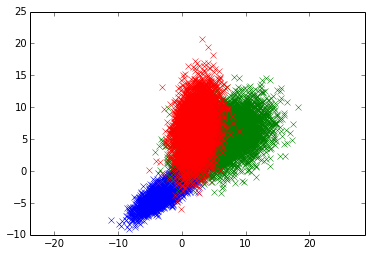

In [4]:
#generate manageable 2d data

numGaussians = 3 #also the number of classes
N = 5000 #num training examples per class
T = 1000 #num testing examples per class
gaussians = []
test = []
for i in range(numGaussians):
    mean = 5 * np.random.randn(2)
    cov = np.random.randint(10, size=(2, 2))
    x_train = np.random.multivariate_normal(mean, cov, N).T
    x_test = np.random.multivariate_normal(mean, cov, T).T
    plt.plot(x_train[0], x_train[1], 'x')
    gaussians.append(x_train) #train data
    test.append(x_test) #test data

     
plt.axis('equal')
plt.show()
X_separated = np.array(gaussians) # shape #(3, 2, N) for 3 classes of N 2-D points each
X = np.concatenate(X_separated, axis=1) #shape (2, 3*N)
X_test = np.concatenate(test, axis = 1)
X = X.T
X_test = X_test.T
#create custom labels
y_tr = np.array([0 for i in range(N)] + [1 for i in range(N)] + [2 for i in range(N)])
y_test = np.array([0 for i in range(T)] + [1 for i in range(T)] + [2 for i in range(T)])




In [5]:
#compute means of each class (empirical)
means =  [np.mean(x, 1) for x in X_separated] #empirical mean of each
mean = np.array(np.mean(means, 0))
print mean.shape

#compute within class scatter (covariances)
covariances = np.array([np.cov(x) for x in X_separated]) #within class covariance matrices
S_W = covariances.sum(axis=0) #S_w, the Within-class Scatter matrix (sum of covariance matrices of each class)

#compute between class scatter (means) - sum of outer products of deviations of the class means from universal mean
S_B = numGaussians*N*sum([np.outer((x - mean), (x - mean)) for x in means]) #Between-class Scatter, shape (2, 2) 

#To solve the generalized eigenvalue problem inv(S_W)*S_B*x = \lambda*x, must compute the eigendecomposition
#of invS_W * S_B. The top-most eigenvector (assoc. with greatest eigenvalue) is the direction of maximimum 
#discriminancy
invS_W = lin.inv(S_W)
Z = invS_W * S_B

#solve the eigenvalue problem, obtain the eigenvectors sorted by decreasing eigenvalue
[vals, vecs] = lin.eig(Z)

#annoying way to sort vecs by the vals...better way?
ev_list = zip(vals, vecs)
ev_list.sort(key=lambda tup:tup[0], reverse=True)
[vals, V] = zip(*ev_list)
V = np.array(V) #shape is (2, 2)



(2,)


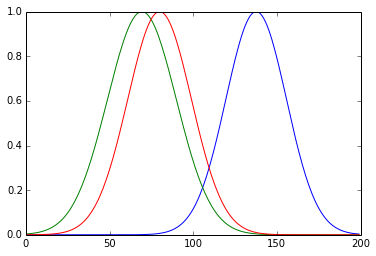

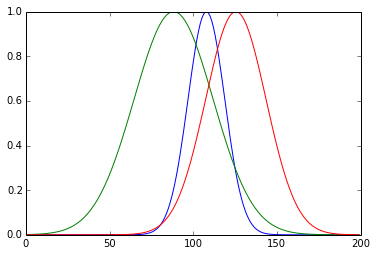

In [6]:
#project data onto the primary axis
proj_classes_first = np.array([np.dot(V[0], X_separated[i]) for i in range(numGaussians)]) #project onto top axis
proj_classes_second = np.array([np.dot(V[1], X_separated[i]) for i in range(numGaussians)]) #project onto next axis


#print error(predict(proj_classes_first.T), labels)

#plot distributions projected onto the first axis found by LDA
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

y_1min = min([min(x) for x in proj_classes_first])
y_1max = max([max(x) for x in proj_classes_first])
for projection in proj_classes_first:
    mu = np.mean(projection)
    sigma = np.std(projection)
    plt.plot(gaussian(np.linspace(y_1min, y_1max, 200), mu, sigma))
plt.show()

#plot projections onto second axis
y_2min = min([min(x) for x in proj_classes_second])
y_2max = max([max(x) for x in proj_classes_second])
for projection in proj_classes_second:
    mu = np.mean(projection)
    sigma = np.std(projection)
    plt.plot(gaussian(np.linspace(y_2min, y_2max, 200), mu, sigma))
plt.show()


#plt.plot(y_1, 'x')
#plt.show()

accuracy of built-in LDA: 0.859666666667
explained variance ratio (first two components): [ 0.83134983  0.16865017]


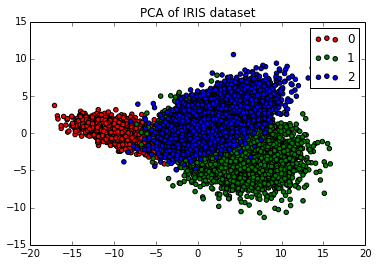

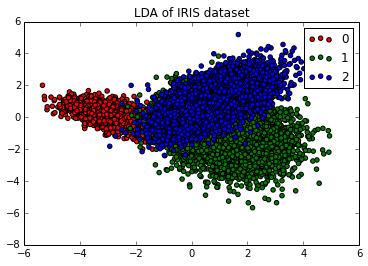

In [8]:
#of course we could have just used the built-in LDA function from scikit (but that's no fun)
#from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

target_names = [0,1, 2]
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y_tr).transform(X)
lda.predict(X_test)
print 'accuracy of built-in LDA: ' + str(lda.score(X_test, y_test))

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r[y_tr == i, 0], X_r[y_tr == i, 1], c=c, label=target_name)
plt.legend()
plt.title('PCA of IRIS dataset')

plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r2[y_tr == i, 0], X_r2[y_tr == i, 1], c=c, label=target_name)
plt.legend()
plt.title('LDA of IRIS dataset')

plt.show()

In [ ]:

scaler = preprocessing.StandardScaler()
mfcc_features = scaler.fit_transform(preprocessing.normalize(np.transpose(JW11['MFCC'])))
articulatory_features = scaler.fit_transform(preprocessing.normalize(np.transpose(JW11['X']).astype(float)))
phone_labels = np.transpose(JW11['P'][0])

n_samples = mfcc_features.shape[0]
n_mfcc_features = mfcc_features.shape[1]
n_articulatory_features = articulatory_features.shape[1]

permutation = np.random.permutation(n_samples)
X1 = np.asarray([mfcc_features[i] for i in permutation])
X2 = np.asarray([articulatory_features[i] for i in permutation])
#Y = np.asarray([binarized_labels[i] for i in permutation])
Phones = np.asarray([phone_labels[i] for i in permutation])

train, dev, test = 25948, 40948, 50948 

#two views of data, X and Y
X1_tr = X1[0:train, :]
X1_dev = X1[train:dev, :]
X1_test = X1[dev:test, :]
X2_tr = X2[0:train, :]
X2_dev = X2[train:dev, :]
X2_test = X2[dev:test, :]
#Y_tr = Y[0:train, :]
#Y_dev = Y[train:dev, :]
#Y_test = Y[dev:test, :]

#labels
Phones_tr = Phones[0:train]
Phones_dev = Phones[train:dev]
Phones_test = Phones[dev:test]

#"core" features of the time series data
baseline_acoustic_tr = X1_tr[:, 118:157]
baseline_acoustic_dev = X1_dev[:, 118:157]
baseline_acoustic_test = X1_test[:, 118:157]
    
#print X1_tr.shape
# print X2_tr.shape
# print Y_tr.shape
# print baseline_acoustic_tr.shape

# print X1_tr.shape
# print X1_dev.shape
# print X1_test.shape
# print Phones_tr.shape

In [14]:
#apply dimensionality reduction to XRMB data
from sklearn.neighbors import KNeighborsClassifier

n_comps = 40
#LDA on View 1
lda = LinearDiscriminantAnalysis(n_components=n_comps)
X_lda1 = lda.fit(X1_tr, Phones_tr).transform(X1_tr)
X1_lda_test = lda.transform(X1_test)
lda.predict(X1_test)
print 'score of LDA on view 1: ' + str(lda.score(X1_test, Phones_test))

#LDA on View 2
lda2 = LinearDiscriminantAnalysis(n_components=n_comps)
X_lda2 = lda2.fit(X2_tr, Phones_tr).transform(X2_tr)
lda2.predict(X2_test)
print 'score of LDA on view 2: ' + str(lda2.score(X2_test, Phones_test))

#PCA on View 1
from sklearn.decomposition import PCA
pca = PCA(n_components=n_comps, whiten=True)
X_pca1 = pca.fit(X1_tr).transform(X1_tr)
X1_pca_test = pca.transform(X1_test)
print 'pca view 1 explained variance ratio: ' + str(pca.explained_variance_ratio_)
print ' and avg likelihood: ' + str(pca.score(X1_tr))
    
#PCA on View 2
from sklearn.decomposition import PCA
pca = PCA(n_components=n_comps, whiten=True)
X_pca2 = pca.fit(X2_tr).transform(X2_tr)
print 'pca view 2 explained variance ratio: ' + str(pca.explained_variance_ratio_)
print ' and avg likelihood: ' + str(pca.score(X2_tr))

#apply both PCA and LDA dimensionality reduction techniqes to the data set and then attempt
#classification by KNN, for instance, to see which reduction technique is most effective

#baseline KNN for view 1
neigh = KNeighborsClassifier(n_neighbors=2)
print 'running knearest neighbor on raw data'
neigh.fit(X1_tr, Phones_tr) 
neigh.predict(X1_test)
print neigh.score(X1_test, Phones_test)

#KNN on LDA transformed data; view 1
neigh2 = KNeighborsClassifier(n_neighbors=2)
print 'running knearest neighbor on LDA View 1'
neigh.fit(X_lda1, Phones_tr) 
neigh.predict(X1_lda_test)
print neigh.score(X1_lda_test, Phones_test)

#KNN on PCA transformed data; view 1
neigh2 = KNeighborsClassifier(n_neighbors=2)
print 'running knearest neighbor on PCA View 1'
neigh.fit(X_pca1, Phones_tr) 
neigh.predict(X1_pca_test)
print neigh.score(X1_pca_test, Phones_test)


score of LDA on view 1: 0.5198
score of LDA on view 2: 0.5804
pca view 1 explained variance ratio: [ 0.0901229   0.06777988  0.06031566  0.05208485  0.04815885  0.04424586
  0.04059334  0.03766653  0.03589603  0.03291267  0.0307196   0.02789757
  0.02663582  0.02363518  0.02145113  0.02089129  0.02036688  0.01931787
  0.01840717  0.01728466  0.0158446   0.01377826  0.0129433   0.01200754
  0.01164998  0.01147664  0.01050254  0.01021653  0.00889549  0.00832286
  0.00740371  0.00724193  0.00613322  0.00550447  0.0052491   0.00480796
  0.00455636  0.00440542  0.00406726  0.00360614]
 and avg likelihood: -161.243057418
pca view 2 explained variance ratio: [  3.11045032e-01   1.83471493e-01   1.41280977e-01   1.01883731e-01
   6.64548783e-02   4.90957778e-02   3.73799225e-02   2.60076135e-02
   1.72954026e-02   1.25367358e-02   9.03381256e-03   7.48737775e-03
   6.67111199e-03   5.30885977e-03   4.42738079e-03   4.06874283e-03
   3.41951357e-03   2.08528465e-03   1.94711067e-03   1.43525380

score of LDA on view 1: 0.5198
score of LDA on view 2: 0.5804
pca view 1 explained variance ratio: [ 0.0901229   0.06777988  0.06031566  0.05208485  0.04815885  0.04424586
  0.04059334  0.03766653  0.03589603  0.03291267  0.0307196   0.02789757
  0.02663582  0.02363518  0.02145113  0.02089129  0.02036688  0.01931787
  0.01840717  0.01728466  0.0158446   0.01377826  0.0129433   0.01200754
  0.01164998  0.01147664  0.01050254  0.01021653  0.00889549  0.00832286
  0.00740371  0.00724193  0.00613322  0.00550447  0.0052491   0.00480796
  0.00455636  0.00440542  0.00406726  0.00360614]
 and avg likelihood: -161.243057418
pca view 2 explained variance ratio: [  3.11045032e-01   1.83471493e-01   1.41280977e-01   1.01883731e-01
   6.64548783e-02   4.90957778e-02   3.73799225e-02   2.60076135e-02
   1.72954026e-02   1.25367358e-02   9.03381256e-03   7.48737775e-03
   6.67111199e-03   5.30885977e-03   4.42738079e-03   4.06874283e-03
   3.41951357e-03   2.08528465e-03   1.94711067e-03   1.43525380e-03
   1.35367163e-03   1.07657714e-03   1.05875467e-03   7.93740747e-04
   6.20871458e-04   5.53444898e-04   3.67436932e-04   2.78245370e-04
   2.18828400e-04   2.04345507e-04   1.53346108e-04   1.20435368e-04
   1.12820632e-04   8.11130863e-05   6.62491029e-05   5.96398651e-05
   5.29870371e-05   3.99024138e-05   3.91040462e-05   3.26955920e-05]
 and avg likelihood: 141.837614188
 
Accuracies achieved by KNN:
 
running knearest neighbor on raw data
0.8085
running knearest neighbor on LDA View 1
0.7777
running knearest neighbor on PCA View 1
0.8192